# Registration
---
The goal of registration is to estimate the transformation matrix from fixed image coordinate system to the moving image coordinate system.

Example : moving MRI from individual space to MNI space

In [1]:
import slicer
import Elastix
import JupyterNotebooksLib as slicernb

import SimpleITK as sitk
import sitkUtils as su

In [2]:
def registration_elastix(fixedVolumeNode, movingVolumeNode):
    """general registration using Elastix"""
    
    #set Parmeter
    elastixLogic = Elastix.ElastixLogic()
    parameterFilenames = elastixLogic.getRegistrationPresets()[0][Elastix.RegistrationPresets_ParameterFilenames]  # generic Non-rigid
    #parameterFilenames = elastixLogic.getRegistrationPresets()[1][Elastix.RegistrationPresets_ParameterFilenames] # generic rigid
    
    #set Output
    outputVolumeNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode")
    outputTransformNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLTransformNode")

    #run
    _ =  elastixLogic.registerVolumes(fixedVolumeNode, movingVolumeNode, parameterFilenames = parameterFilenames, outputVolumeNode =  outputVolumeNode, outputTransformNode = outputTransformNode )
    
    return outputVolumeNode, outputTransformNode

In [3]:
def registration_general(fixedVolumeNode, movingVolumeNode):
    """general registration using BRAINS"""
    
    outputVolumeNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLScalarVolumeNode")
    outputTransformNode = slicer.mrmlScene.AddNewNodeByClass("vtkMRMLTransformNode")
    
    #Set Parmeter
    parameters = {}
    parameters["fixedVolume"] = fixedVolumeNode
    parameters["movingVolume"] = movingVolumeNode
    parameters["initializeTransformMode"] = "useGeometryAlign"
    parameters["useRigid"] = True
    #parameters["useScaleVersor3D"] = True
    parameters["outputVolume"] = outputVolumeNode
    #parameters["useScaleSkewVersor3D"] = True
    #parameters["useAffine"] = True
    parameters["linearTransform"] = outputTransformNode
   

     #run
    cliNode = slicer.cli.runSync(slicer.modules.brainsfit, None, parameters)
    
    # Process results
    if cliNode.GetStatus() & cliNode.ErrorsMask:
        # error
        errorText = cliNode.GetErrorText()
        slicer.mrmlScene.RemoveNode(cliNode)
        raise ValueError("CLI execution failed: " + errorText)

    # success
    #slicer.mrmlScene.RemoveNode(cliNode)
    
    return outputVolumeNode, outputTransformNode

In [4]:
def load_nii(path):
    """Load .nii or .nrrd to sitk image"""
    filetype = path.split("\\")[-1].split(".")[-1]

    
    reader = sitk.ImageFileReader()    

    if filetype == "nii" or "gz" :
        reader.SetImageIO("NiftiImageIO")
    elif filetype == "nrrd"  :
        reader.SetImageIO("NrrdImageIO")
    reader.SetFileName(path)

    image = reader.Execute()
    
    return image, reader

### Load MRI and MNI  
### show unregistered images

IntProgress(value=0)

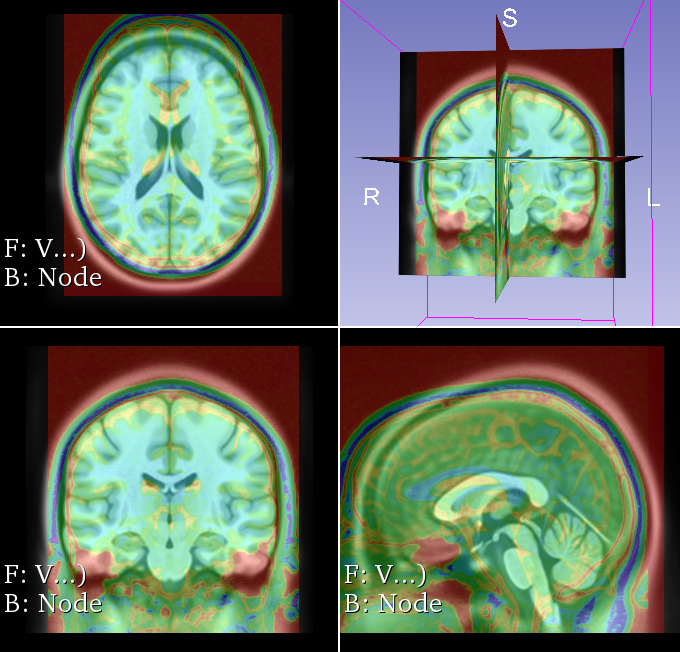

In [7]:
# clear view of 3Dslicer
slicer.mrmlScene.Clear()

# you can load data by downloadFromURL
MRvolumeNode = slicernb.downloadFromURL(uris="https://github.com/Slicer/SlicerTestingData/releases/download/MD5/39b01631b7b38232a220007230624c8e", fileNames="MRHead.nrrd", nodeNames="Volume")

# set colormap of MRI 
MRdisplayNode = MRvolumeNode.GetDisplayNode()
MRdisplayNode.SetAndObserveColorNodeID("vtkMRMLColorTableNodeRainbow")


# Or load local data and push to slicer
MNIimage, _ = load_nii('./data/mni_icbm152_t1_tal_nlin_sym_09c.nii')
MNIvolumeNode = su.PushVolumeToSlicer(MNIimage)

# show a small (30%) image
slicernb.AppWindow.setWindowSize(scale=0.3)
slicernb.showSliceViewAnnotations(True)

# set MNI in backlound and MRI in foregound
slicer.util.setSliceViewerLayers(background=MNIvolumeNode, foreground=MRvolumeNode)
slicer.util.setSliceViewerLayers(foregroundOpacity=0.3)

# show all views of slices in 3dview
layoutManager = slicer.app.layoutManager()
for sliceViewName in layoutManager.sliceViewNames():
    controller = layoutManager.sliceWidget(sliceViewName).sliceController()
    controller.setSliceVisible(True)

# rotate 3dview
threeDWidget = layoutManager.threeDWidget(0)
threeDView = threeDWidget.threeDView()
threeDView.yaw()

# display all view
display(slicernb.ViewDisplay("FourUp"))

### Rigid registraion using brainsfit module

Rigid registraion register images by rotation and translation.  
This simple transformation could be enough to align simple structures as this contrains the solution space with no non-rigid deformation. 
 
- fixed volume : MNI
- movind volume : MRI

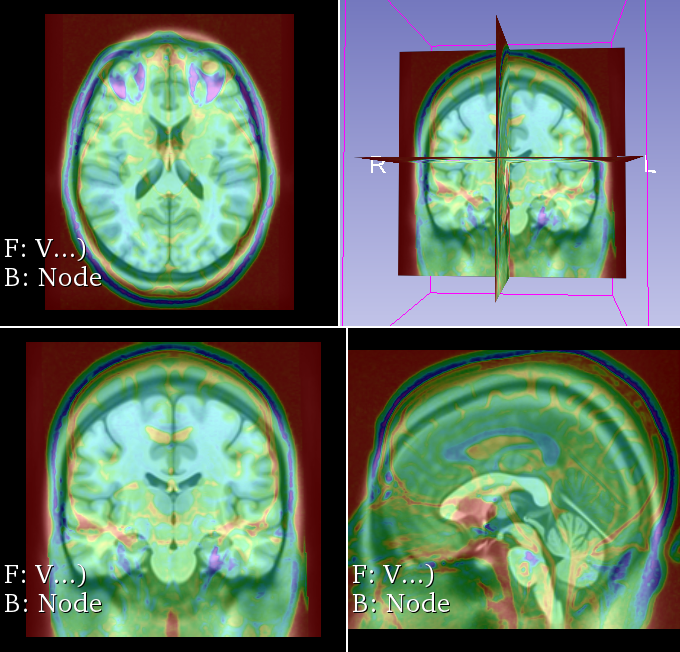

In [8]:
MRIregistered, _ = registration_general(fixedVolumeNode = MNIvolumeNode, movingVolumeNode = MRvolumeNode)

# set colormap of registered MRI 
MRIregistereddisplay = MRIregistered.GetDisplayNode()
MRIregistereddisplay.SetAndObserveColorNodeID("vtkMRMLColorTableNodeRainbow")

# set MNI in backlound and MRI in foregound
slicer.util.setSliceViewerLayers(background=MNIvolumeNode, foreground=MRIregistered)
slicer.util.setSliceViewerLayers(foregroundOpacity=0.3)
    
# show a small (30%) image
slicernb.AppWindow.setWindowSize(scale=0.3)
slicernb.showSliceViewAnnotations(True)
display(slicernb.ViewDisplay("FourUp"))

### Non-Rigid registration using elastix module

Non-rigid registraion register images by rotation and translation allowing shearing and scaling.  
This transformation deforms the solution images. Thus, it is advantageus to accomodate anatomical, physiological and pathological variability between tissues.

- fixed volume : MNI
- movind volume : MRI

Volume registration is started in working directory: C:/Users/user/AppData/Local/Temp/Slicer/Elastix/20211028_130225_668
Register volumes...


toVTKString is deprecated! Conversion is no longer necessary.


Register volumes using: C:\Users\user\AppData\Local\NA-MIC\Slicer 4.11.20210226\NA-MIC\Extensions-29738\SlicerElastix\lib\Slicer-4.11\elastix.exe: ['-f', 'C:/Users/user/AppData/Local/Temp/Slicer/Elastix/20211028_130225_668\\input\\fixed.mha', '-m', 'C:/Users/user/AppData/Local/Temp/Slicer/Elastix/20211028_130225_668\\input\\moving.mha', '-out', 'C:/Users/user/AppData/Local/Temp/Slicer/Elastix/20211028_130225_668\\result-transform', '-p', 'C:\\Users\\user\\AppData\\Local\\NA-MIC\\Slicer 4.11.20210226\\NA-MIC\\Extensions-29738\\SlicerElastix\\lib\\Slicer-4.11\\qt-scripted-modules\\Resources\\RegistrationParameters\\Parameters_Rigid.txt', '-p', 'C:\\Users\\user\\AppData\\Local\\NA-MIC\\Slicer 4.11.20210226\\NA-MIC\\Extensions-29738\\SlicerElastix\\lib\\Slicer-4.11\\qt-scripted-modules\\Resources\\RegistrationParameters\\Parameters_BSpline.txt']
Generate output...
Generate output using: C:\Users\user\AppData\Local\NA-MIC\Slicer 4.11.20210226\NA-MIC\Extensions-29738\SlicerElastix\lib\Slicer

loadNodeFromFile `returnNode` argument is deprecated. Loaded node is now returned directly if `returnNode` is not specified.


Registration is completed


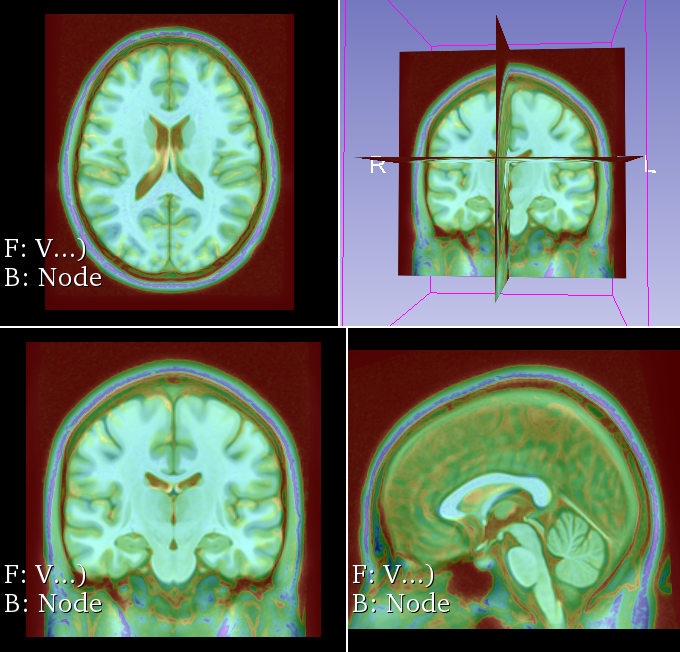

In [9]:
MRIregistered, _ = registration_elastix(fixedVolumeNode = MNIvolumeNode, movingVolumeNode = MRvolumeNode)

# set colormap of registered MRI 
MRIregistereddisplay = MRIregistered.GetDisplayNode()
MRIregistereddisplay.SetAndObserveColorNodeID("vtkMRMLColorTableNodeRainbow")

# set MNI in backlound and MRI in foregound
slicer.util.setSliceViewerLayers(background=MNIvolumeNode, foreground=MRIregistered)
slicer.util.setSliceViewerLayers(foregroundOpacity=0.3)
 
# show a small (30%) image
slicernb.AppWindow.setWindowSize(scale=0.3)
slicernb.showSliceViewAnnotations(True)
display(slicernb.ViewDisplay("FourUp"))